# Statsmodels buat ngecek regresi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

Jangan lupa kondisi yg harus terpenuhi buat regresi = no multicolinearity.

i think we should learn more about feature selection! remember, Garbage In Garbage Out

In [2]:
df = pd.read_csv('data_bersih_ver2.csv')
df['kamar'] = df['kamar_mandi'] + df['kamar_tidur']
df = df.drop(['Unnamed: 0','taman','garasi','kamar_mandi','kamar_tidur'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13496 entries, 0 to 13495
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   luas_bangunan  13496 non-null  float64
 1   luas_tanah     13496 non-null  float64
 2   harga          13496 non-null  float64
 3   kecamatan      13496 non-null  object 
 4   kolam_renang   13496 non-null  bool   
 5   gym            13496 non-null  bool   
 6   listrik        13496 non-null  float64
 7   jumlah_lantai  13496 non-null  int64  
 8   kamar          13496 non-null  int64  
dtypes: bool(2), float64(4), int64(2), object(1)
memory usage: 764.5+ KB


In [3]:
num = [i for i in df.columns if df[i].dtypes in ['int64', 'float']]
cat = [i for i in df.columns if df[i].dtypes in ['O', 'bool']]

In [4]:
df[cat] = df[cat].astype('O')

In [5]:
from feature_engine.encoding import DecisionTreeEncoder as DTE

In [6]:
#np.bool ga ada?
encode = DTE(variables = ['kecamatan'])
encode.fit(df,df['harga'])

DecisionTreeEncoder(param_grid={'max_depth': [1, 2, 3, 4]},
                    variables=['kecamatan'])

In [7]:
from feature_engine.encoding import OrdinalEncoder as OE

In [8]:
oe = OE(variables = [i for i in cat if i != 'kecamatan'])
oe.fit(df,df['harga'])

OrdinalEncoder(variables=['kolam_renang', 'gym'])

In [9]:
x = oe.transform(encode.transform(df))

In [10]:
from sklearn.preprocessing import StandardScaler as ss

In [11]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [12]:
import statsmodels.api as sm

In [13]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
y = y_scale.transform(df[['harga']])
x = pd.DataFrame(x)
y = pd.DataFrame(y)
x.columns = df.drop('harga', axis = 1).columns
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [14]:
model = sm.OLS(y, x).fit()

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     3463.
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        19:22:07   Log-Likelihood:                -11617.
No. Observations:               13496   AIC:                         2.325e+04
Df Residuals:                   13487   BIC:                         2.332e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.551e-17      0.005   1.13e-14      1.000      -0.010       0.010
luas_bangunan     0.3698      0.008     47.461      0.000       0.355       0.385
luas_tanah        0.2512      0.007     34.585      0.000       0.237       0.265
kecamatan         0.3974      0.005     74.173      0.000       0.387       0.408
kolam_renang      0.0141      0.005      2.652      0.008       0.004       0.025
gym               0.0132      0.005      2.643      0.008       0.003       0.023
listrik           0.0467      0.005      9.235      0.000       0.037       0.057
jumlah_lantai    -0.0192      0.005     -3.666      0.000      -0.029      -0.009
kamar            -0.0316      0.005     -5.790      0.000      -0.042      -0.021
==============================================================================
Omnibus:                    17238.929   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25504524.677
Skew:                           6.243   Prob(JB):                         0.00
Kurtosis:                     215.600   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,kecamatan,3.974494e-01
1,luas_bangunan,3.698420e-01
2,luas_tanah,2.511760e-01
6,listrik,4.674952e-02
4,kolam_renang,1.413695e-02
5,gym,1.321938e-02
0,const,5.551115e-17
7,jumlah_lantai,-1.921743e-02
8,kamar,-3.157702e-02


In [17]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [18]:
y_pred = model.predict(x)
sqrt(mse(y_pred, y))

0.5722376890114869

In [19]:
from scipy import stats

In [20]:
for k in cat+num:
    if df[k].nunique() <100:
        print("="*45,f' {k} ',"="*45)
        var = [i for i in df[k].unique()]
        pair = {}
        udah = []
        for i in var:
            for j in var:
                if (j not in udah) & (i != j):
                    ttest = stats.ttest_ind(a = df[df[k] == i]['harga'],
                                            b = df[df[k] == j]['harga'])
                    p_value = ttest.pvalue
                    pair[f'{i} - {j}'] = p_value
            udah.append(i)
        count = 0
        for i,j in pair.items():
            if j >= 0.05:
                print(i)
                count += 1
        print(f'{k}: {count/len(pair)*100}')
        print("="*100,end = '\n')

=============================================  kecamatan  =============================================
Cilandak - Tebet
Cilandak - Pasar Minggu
Cilandak - Pancoran
Cilandak - Gambir
Kebayoran Baru - Kebayoran Lama
Kebayoran Baru - Setiabudi
Jagakarsa - Koja
Jagakarsa - Cakung
Jagakarsa - Kramat Jati
Jagakarsa - Makasar
Jagakarsa - Kalideres
Jagakarsa - Cengkareng
Tebet - Pasar Minggu
Tebet - Jatinegara
Tebet - Senen
Tebet - Gambir
Tebet - Palmerah
Pasar Minggu - Pancoran
Pasar Minggu - Jatinegara
Pasar Minggu - Senen
Pasar Minggu - Gambir
Pasar Minggu - Palmerah
Kebayoran Lama - Setiabudi
Pesanggrahan - Tanjung Priok
Pesanggrahan - Kelapa Gading
Pesanggrahan - Pademangan
Pesanggrahan - Pulo Gadung
Pesanggrahan - Matraman
Pesanggrahan - Jatinegara
Pesanggrahan - Senen
Pesanggrahan - Kemayoran
Pesanggrahan - Cempaka Putih
Pesanggrahan - Sawah Besar
Pesanggrahan - Johar Baru
Pesanggrahan - Palmerah
Pesanggrahan - Kembangan
Pesanggrahan - Kebon Jeruk
Pesanggrahan - Taman Sari
Pesanggrahan

# EDA

luas_bangunan


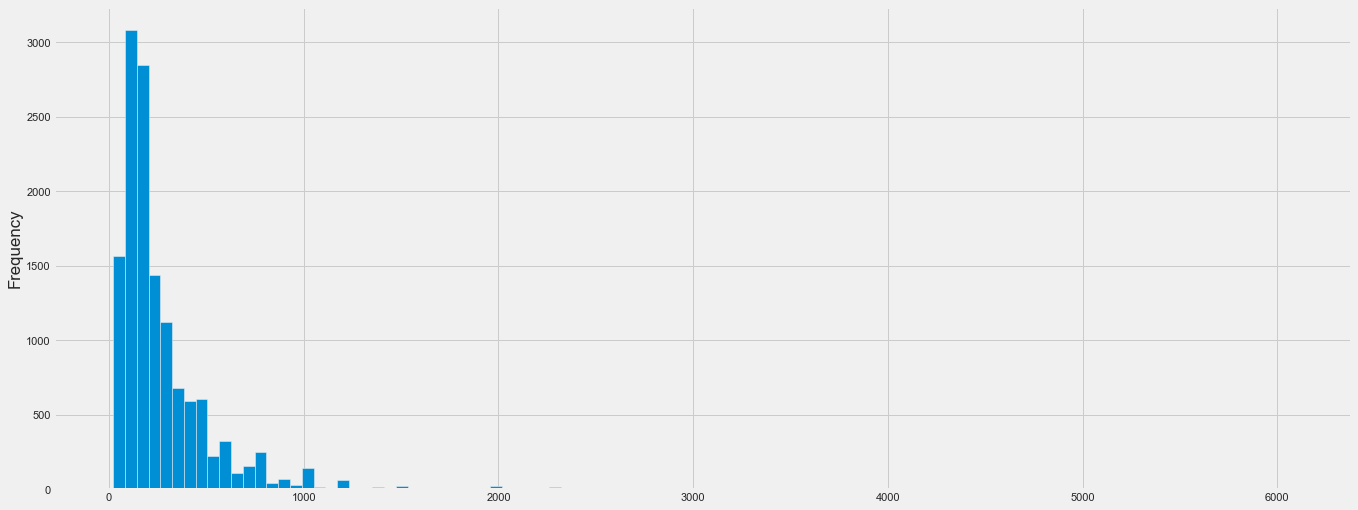

luas_tanah


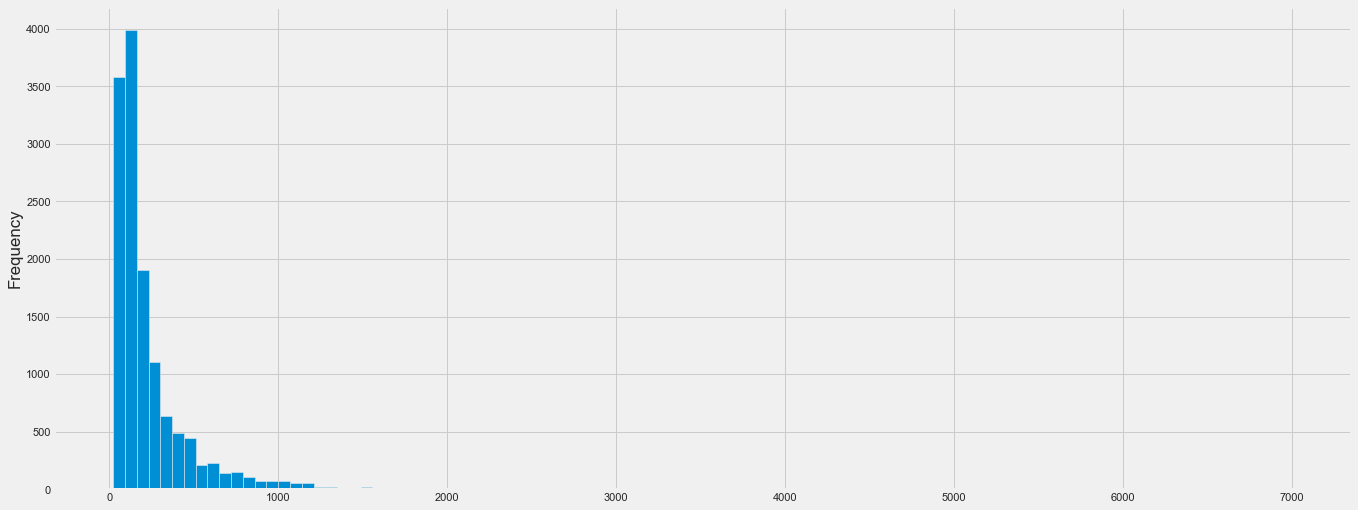

harga


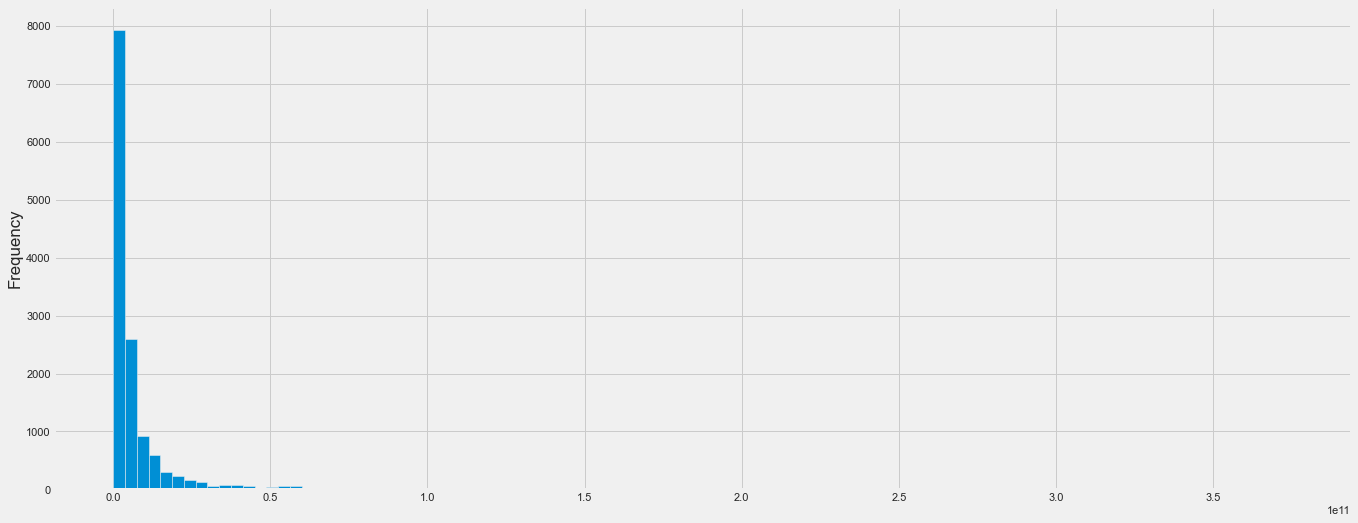

listrik


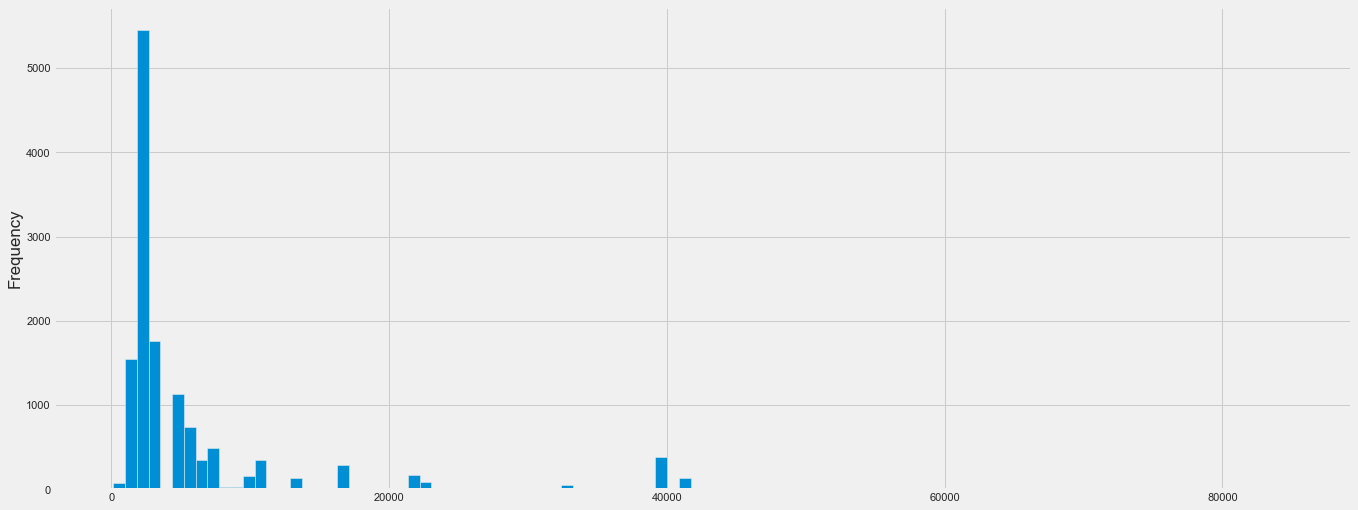

jumlah_lantai


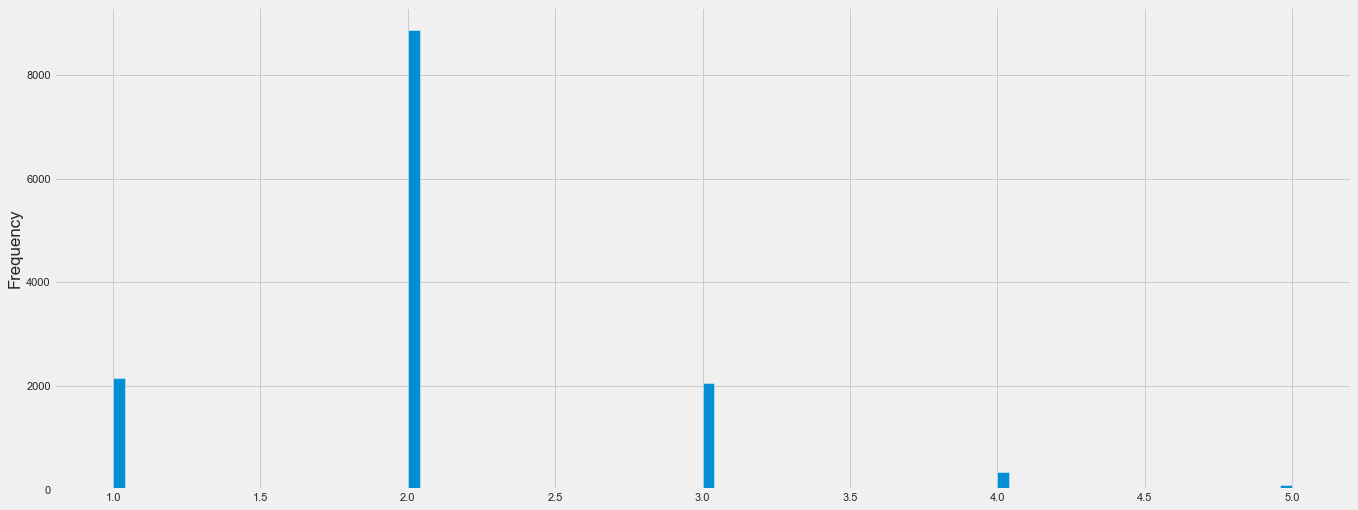

kamar


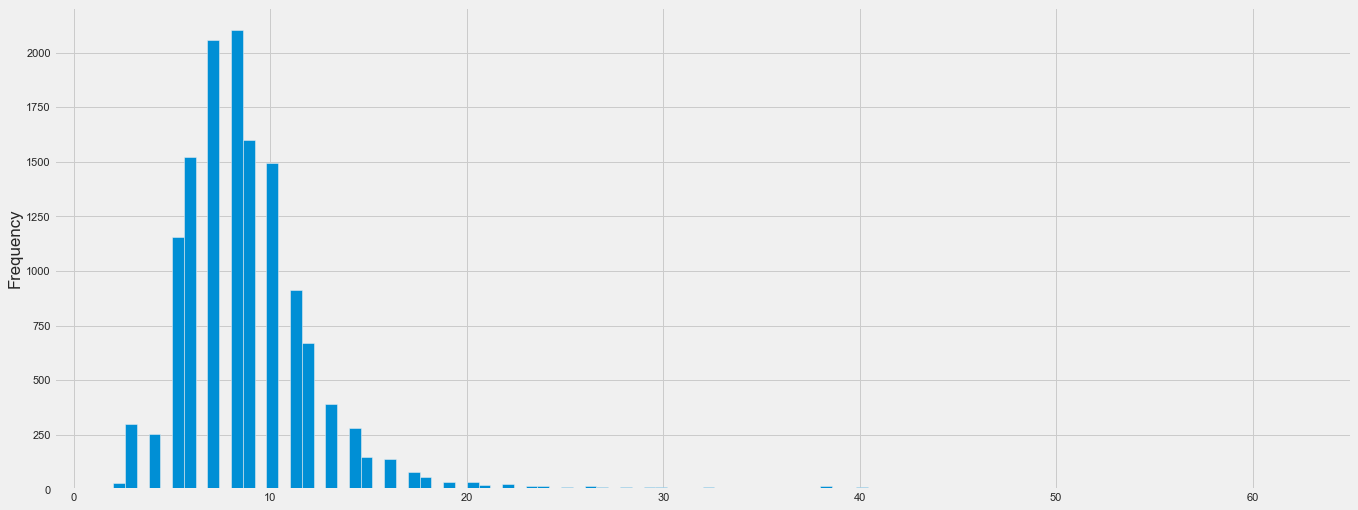

In [21]:
for i in num:
    print(i)
    df[i].plot.hist(bins = 100)
    plt.show()

luas_bangunan


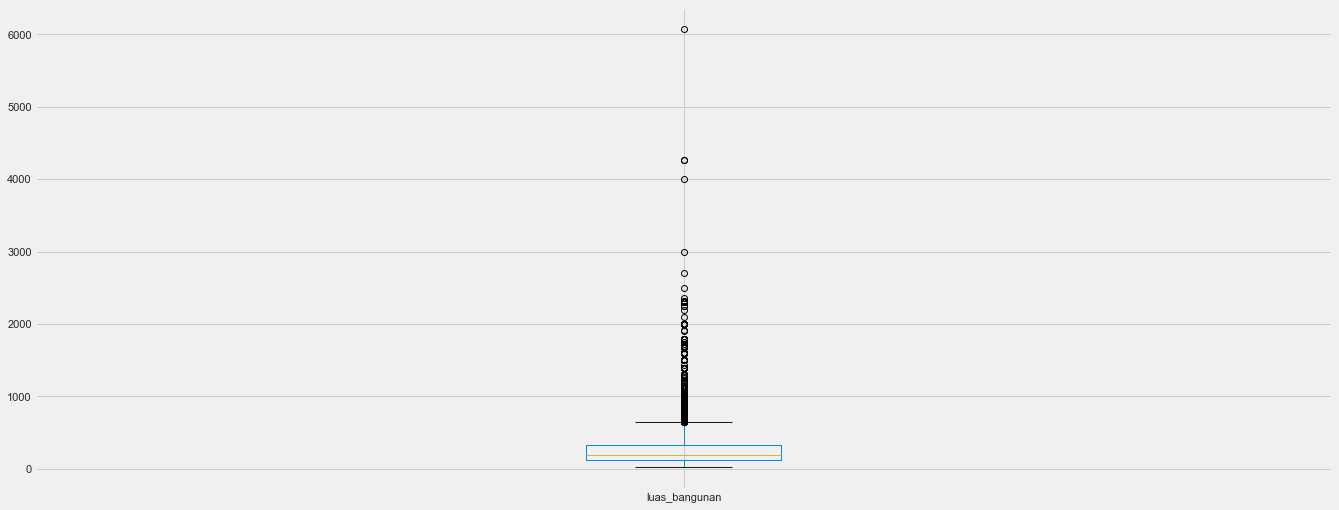

luas_tanah


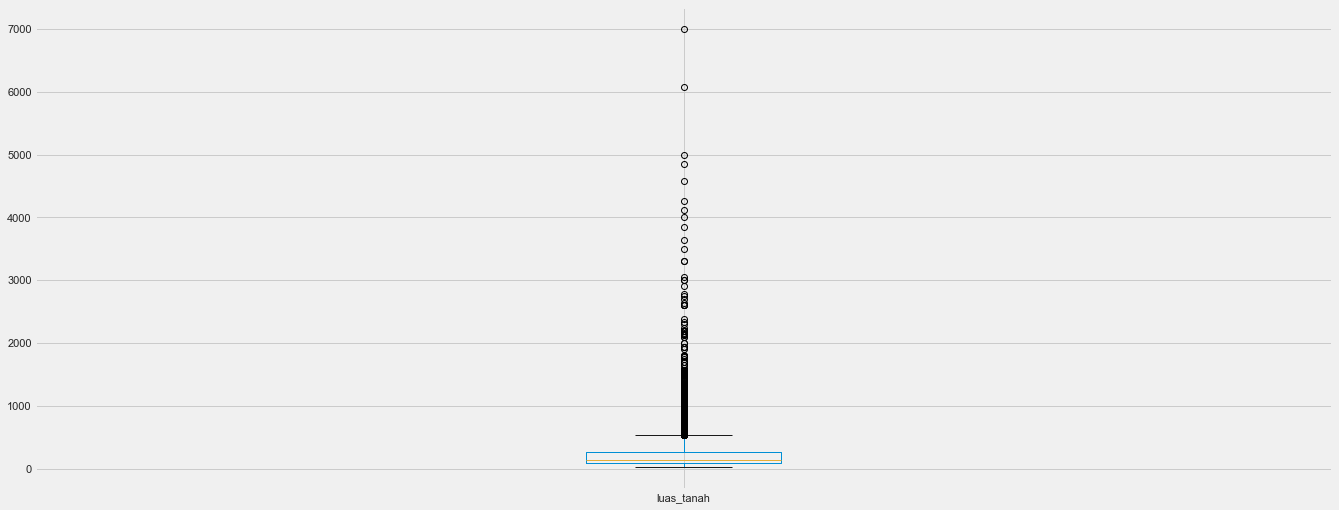

harga


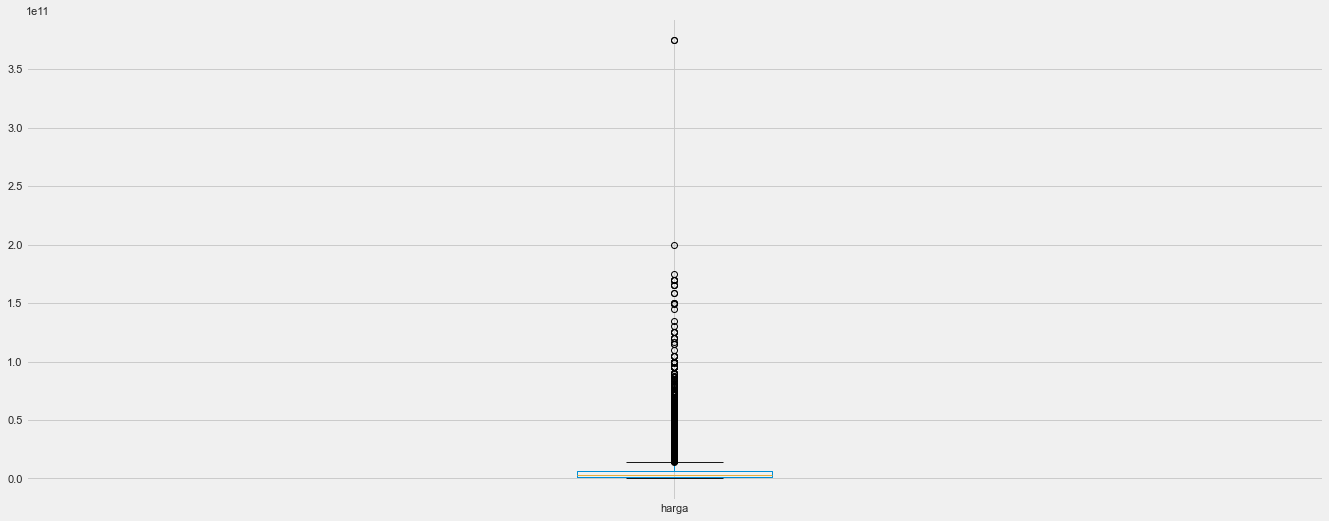

listrik


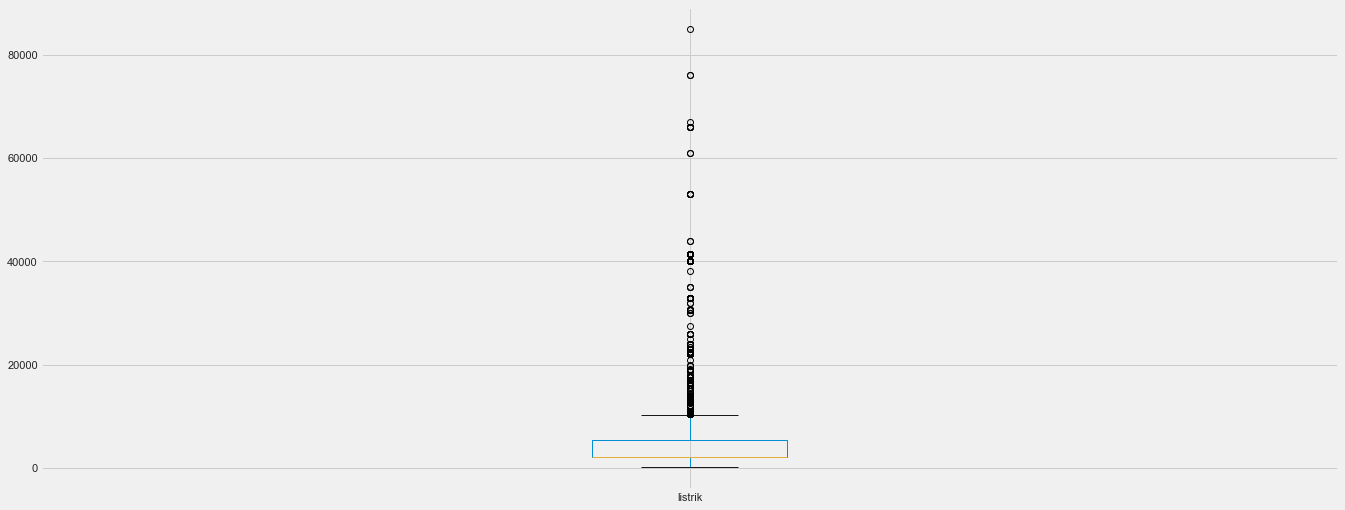

jumlah_lantai


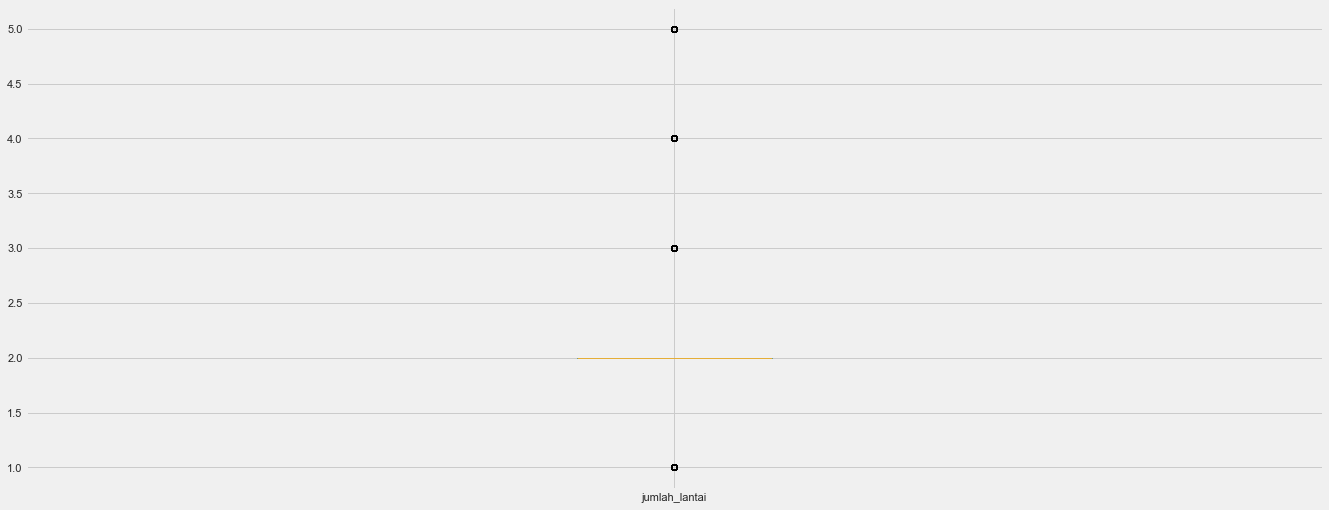

kamar


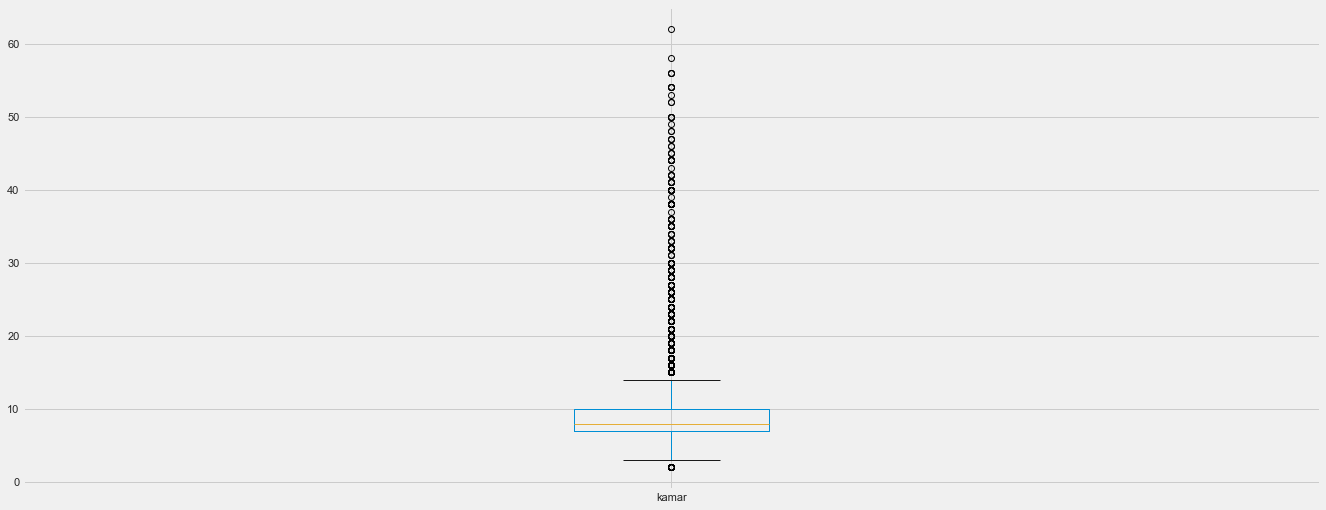

In [22]:
for i in num:
    print(i)
    df[i].plot.box()
    plt.show()

kecamatan


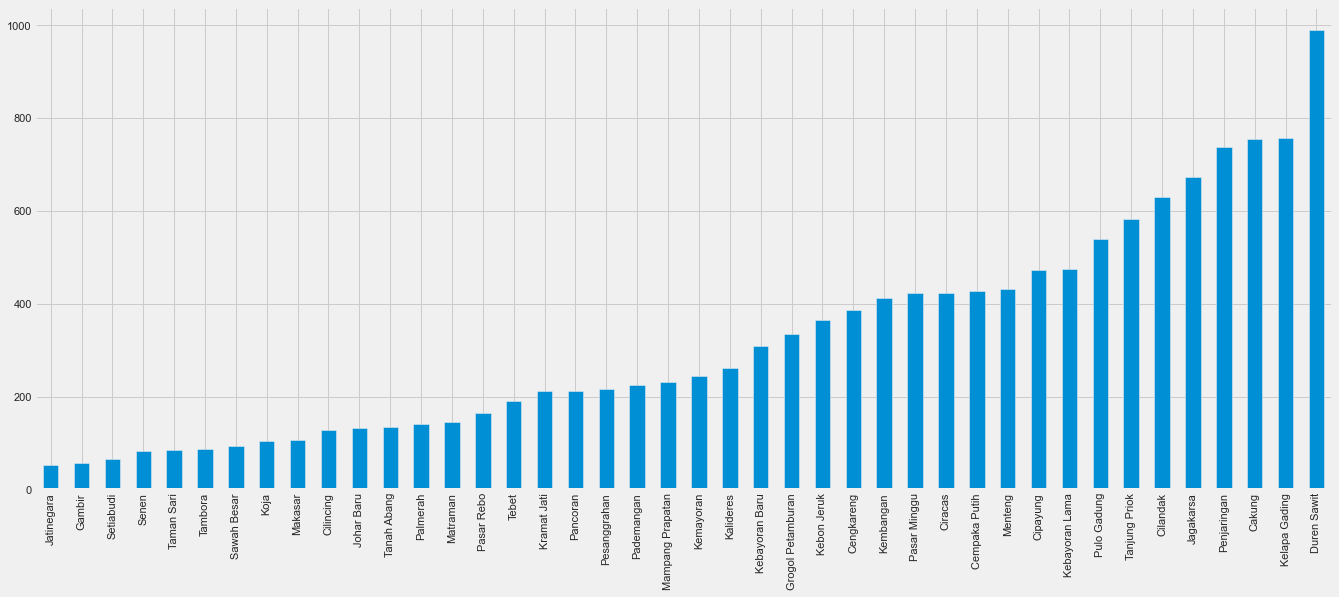

kolam_renang


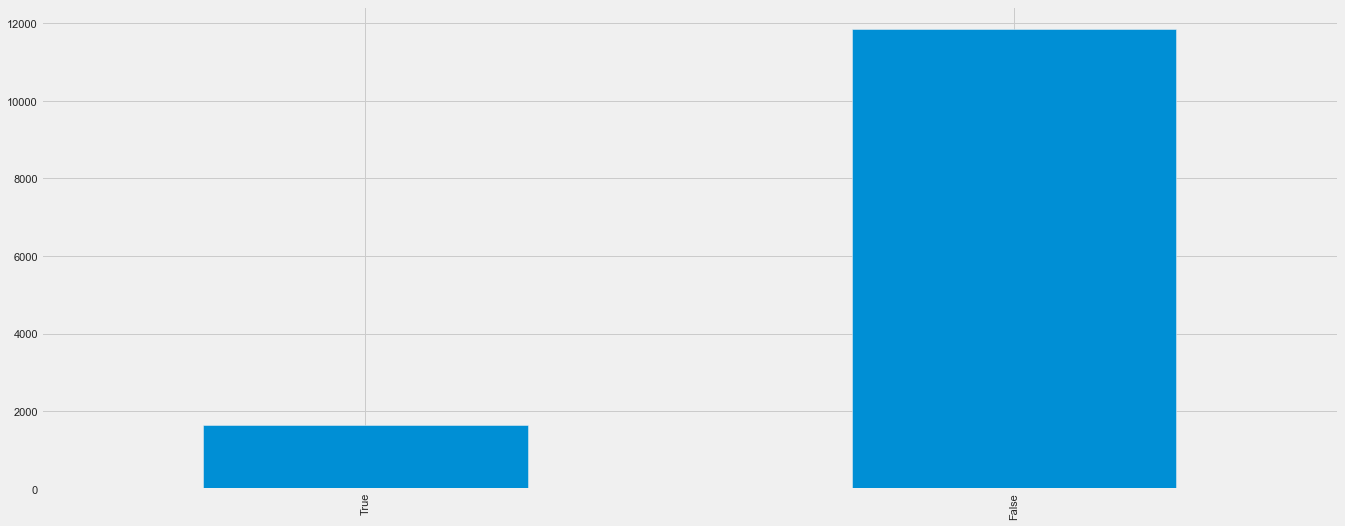

gym


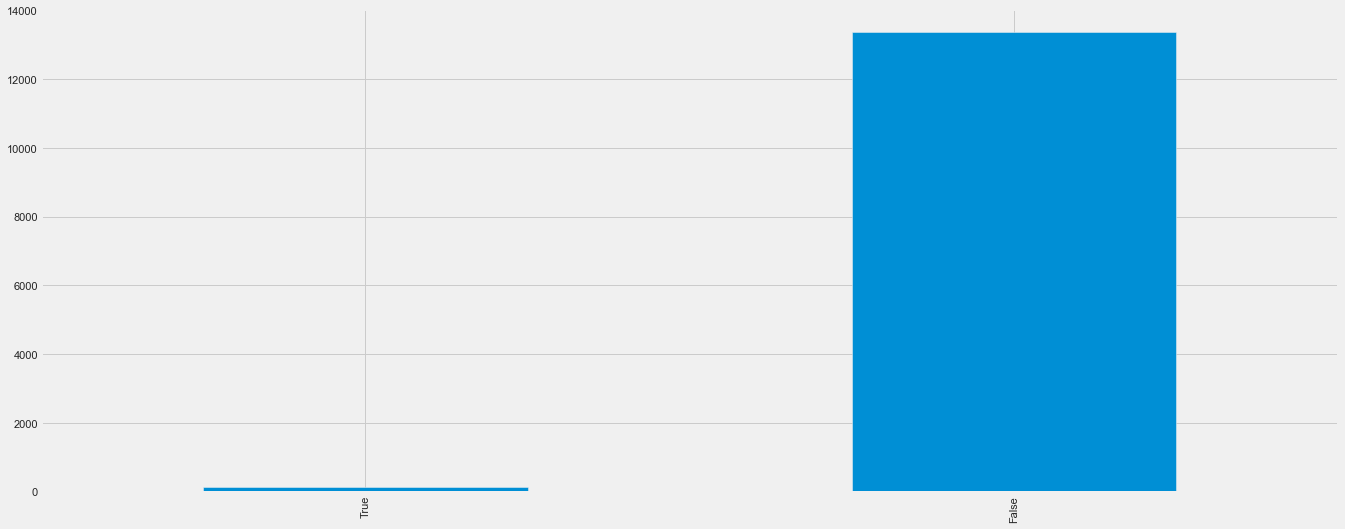

In [23]:
for i in cat:
    print(i)
    df[i].value_counts().sort_values().plot.bar()
    plt.show()

Masukin target (harga)

luas_bangunan


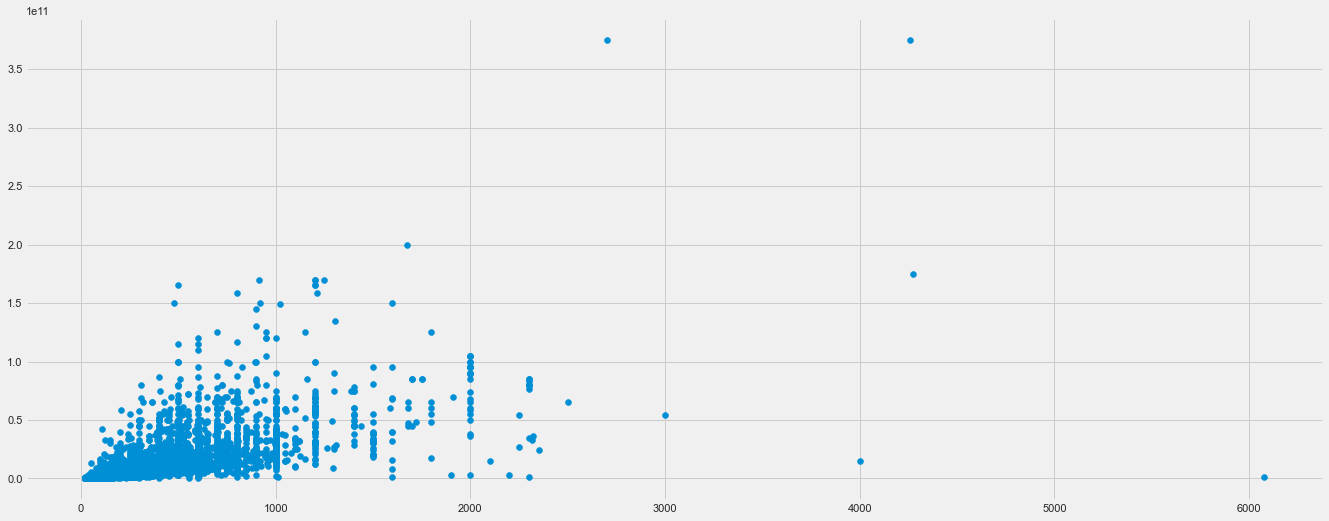

luas_tanah


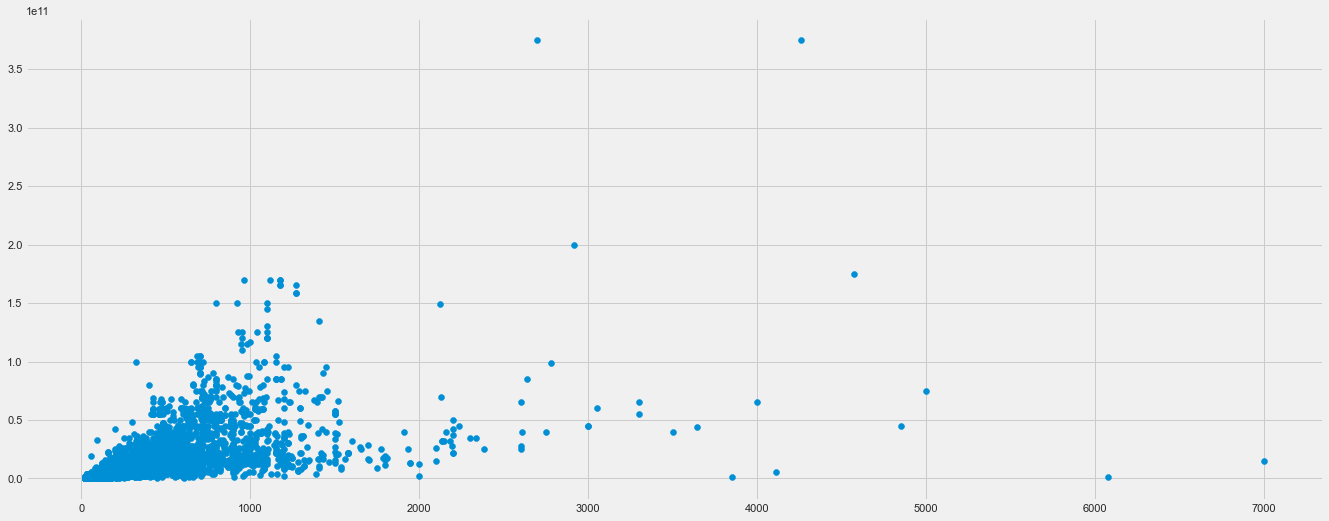

listrik


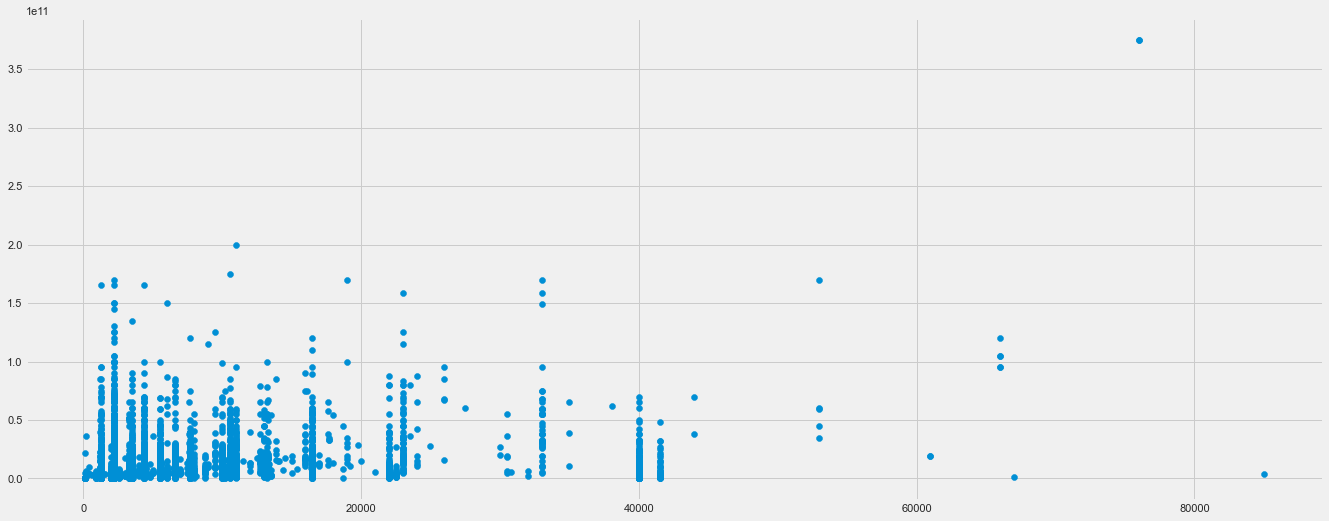

jumlah_lantai


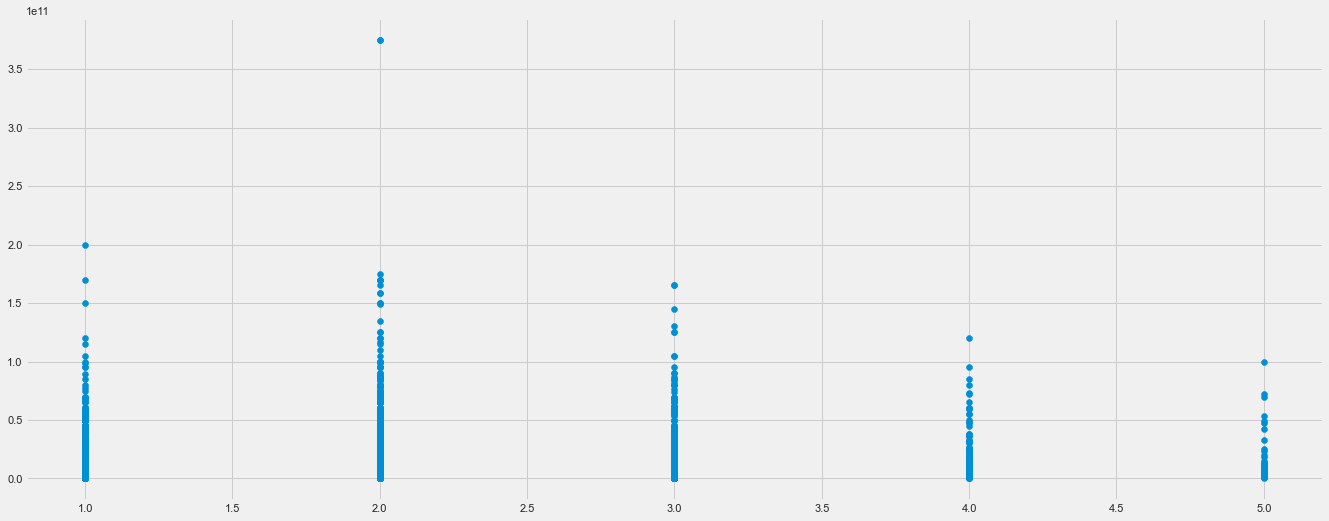

kamar


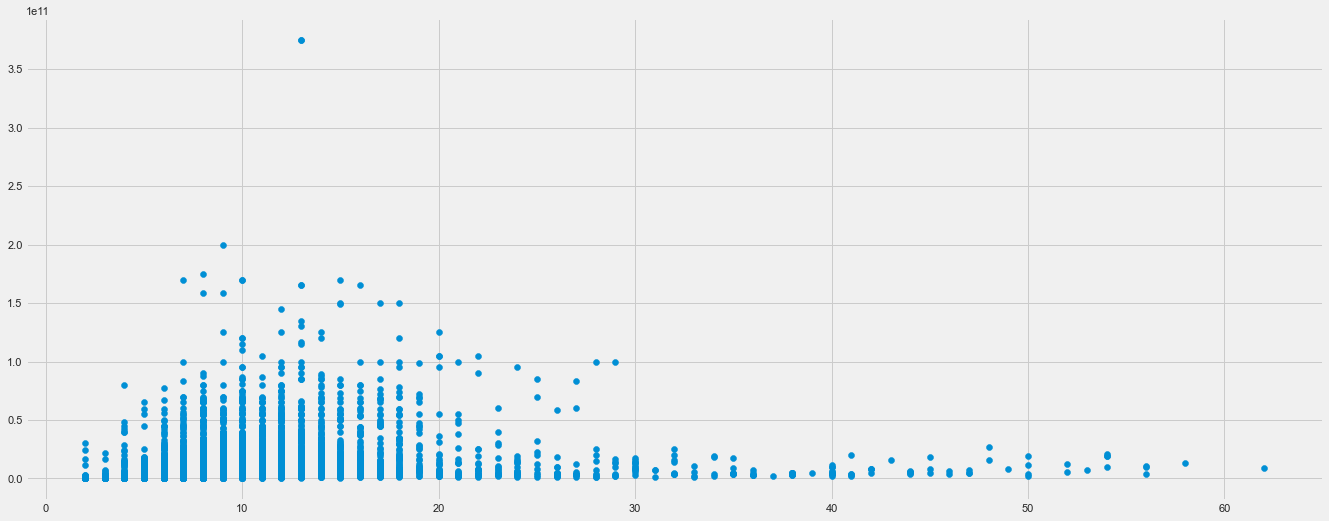

kecamatan


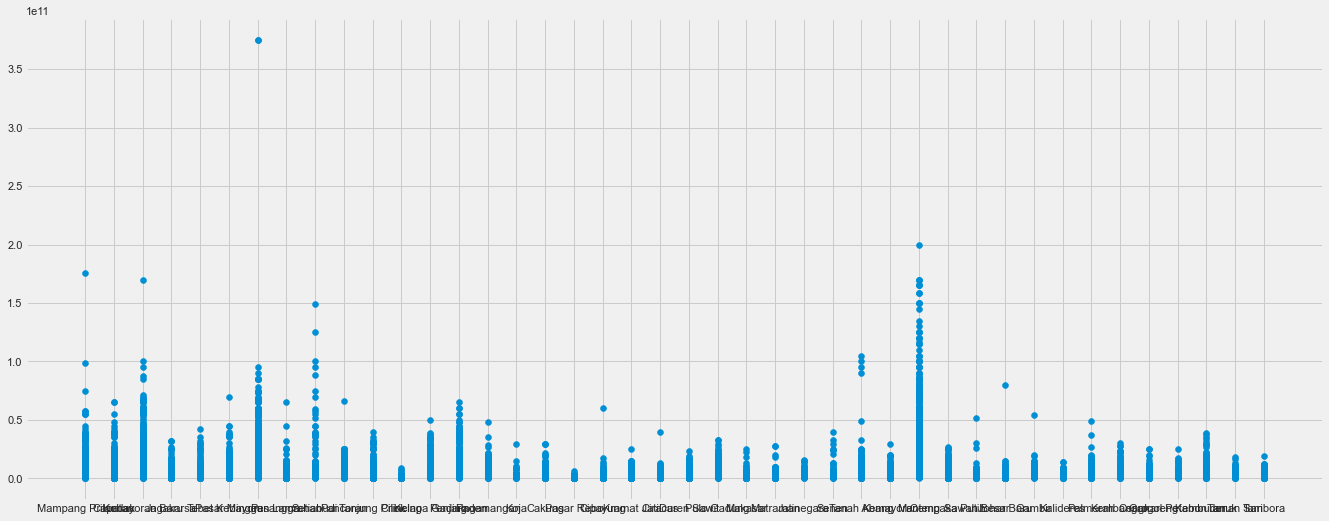

kolam_renang


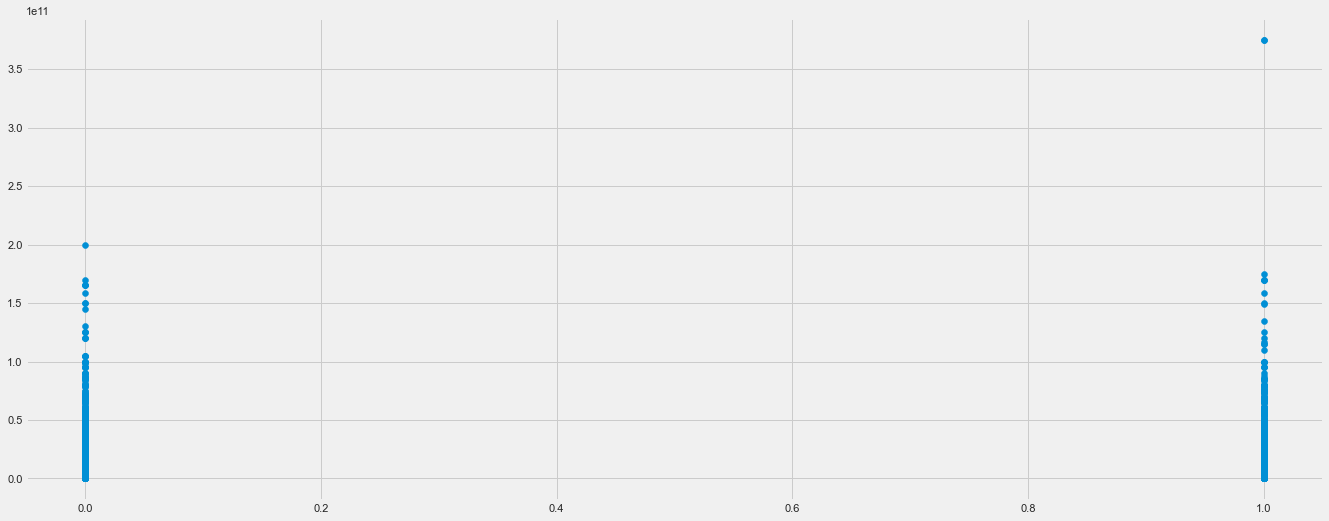

gym


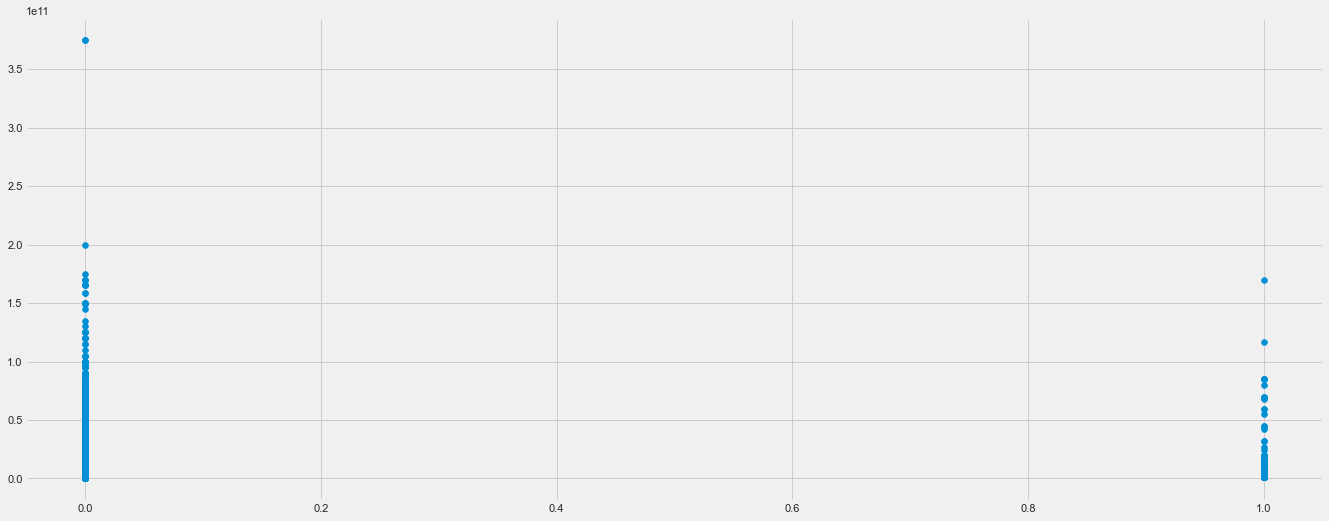

In [24]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df[i],df['harga'])
        plt.show()

kecamatan


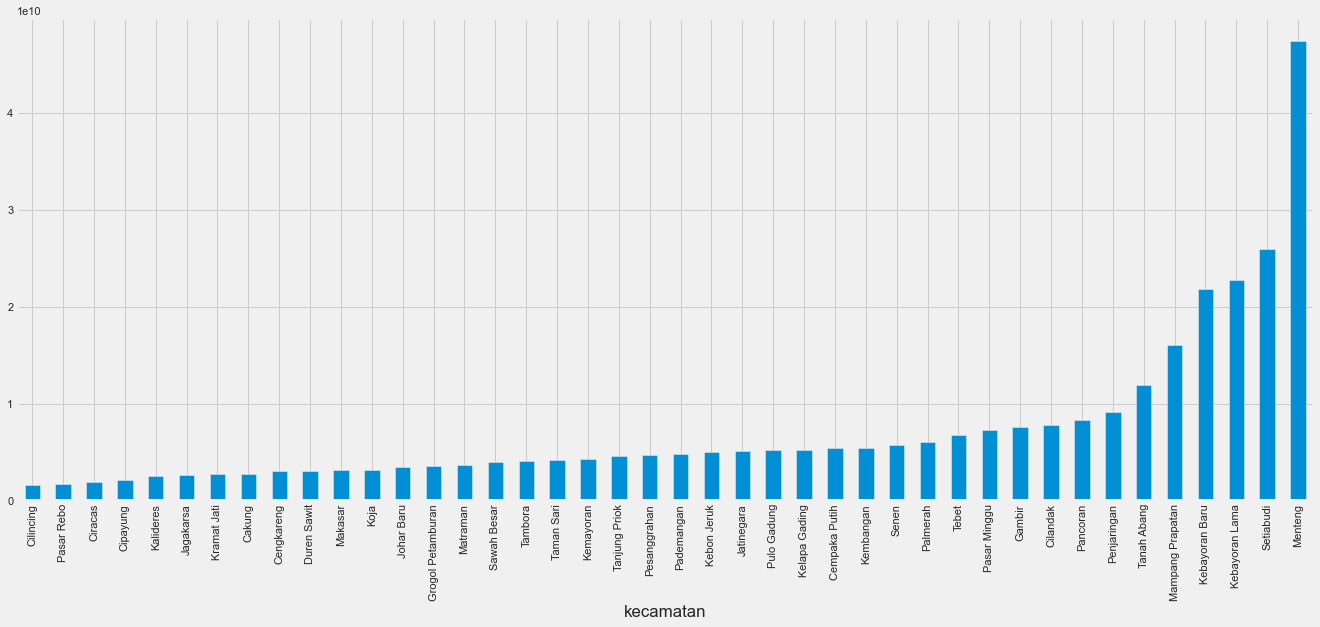

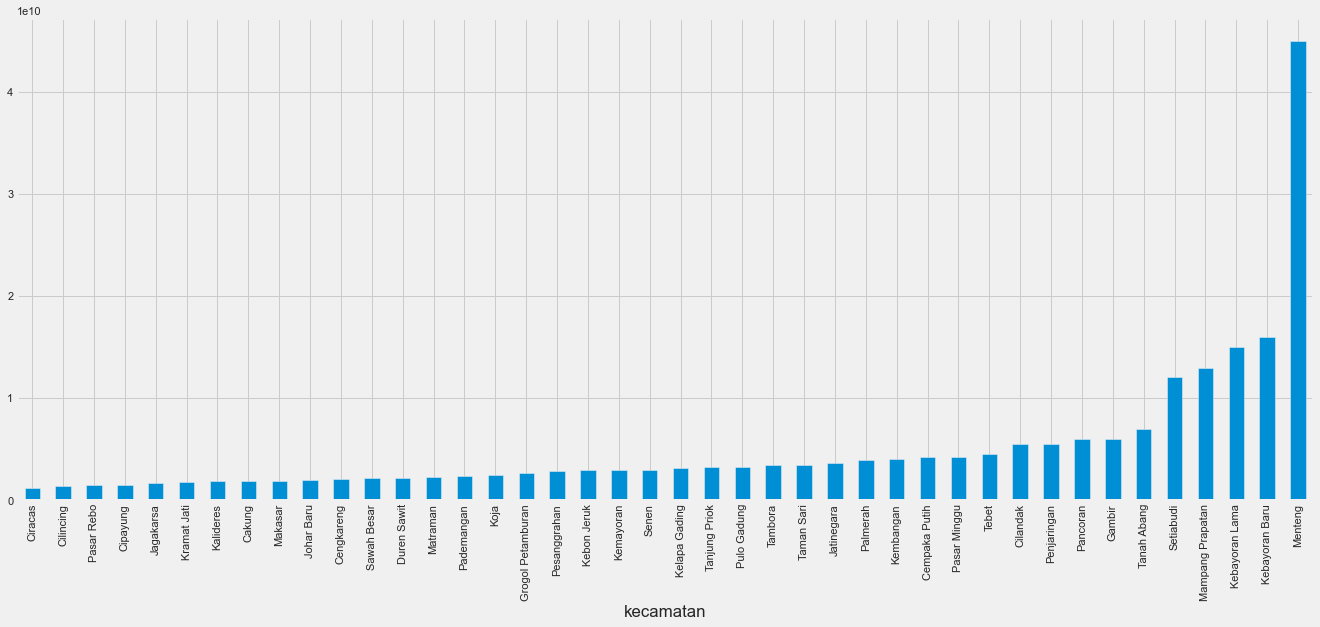

kolam_renang


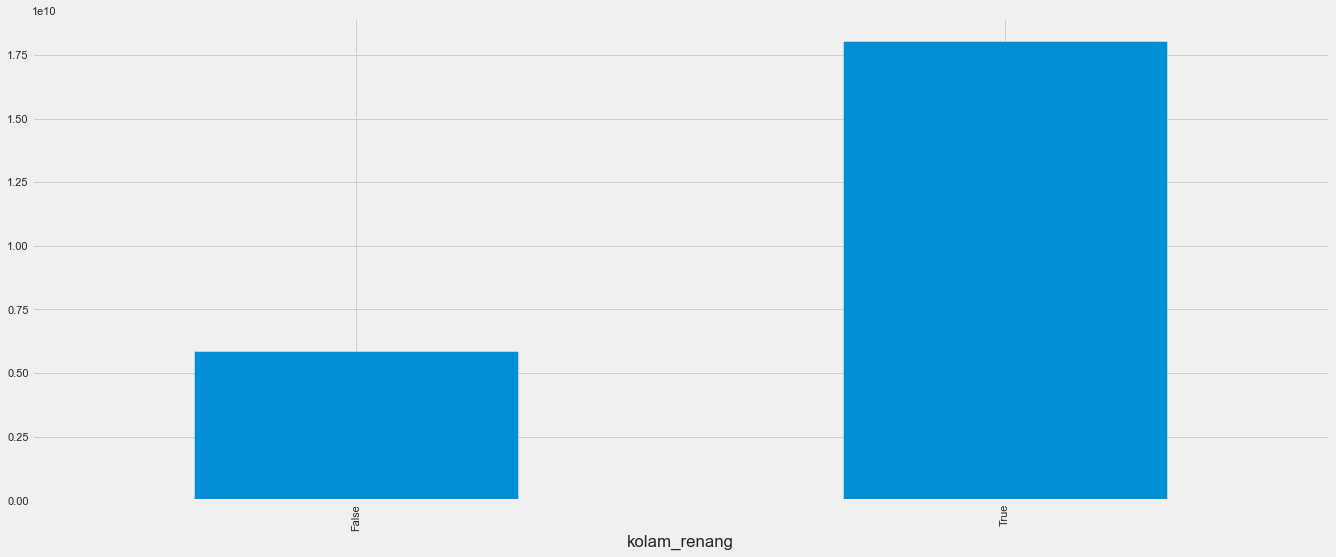

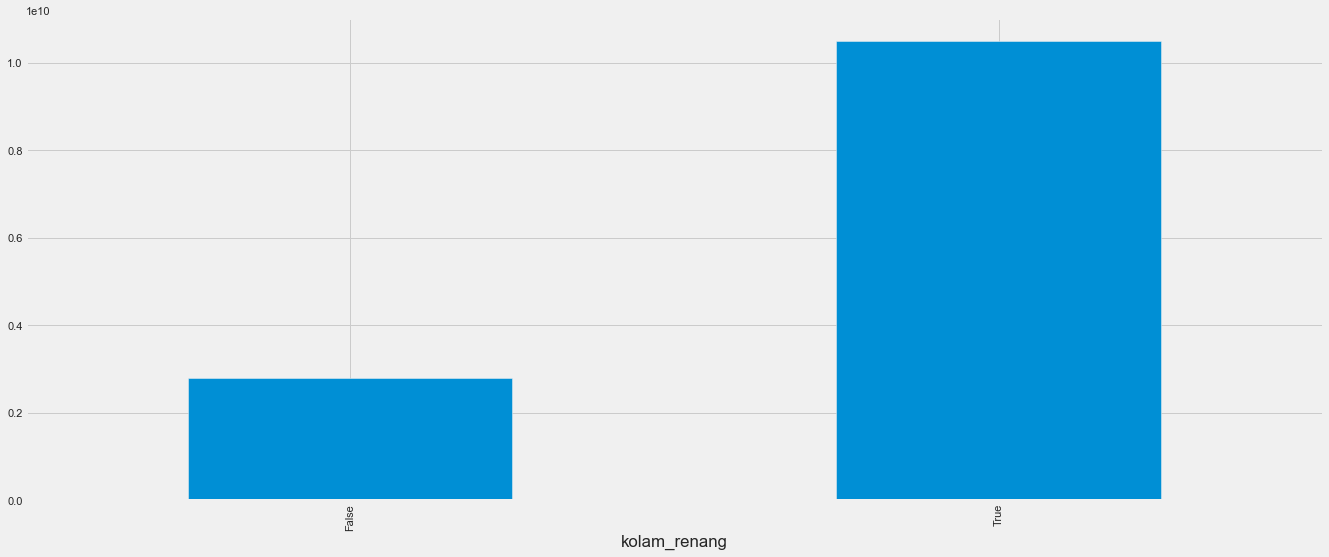

gym


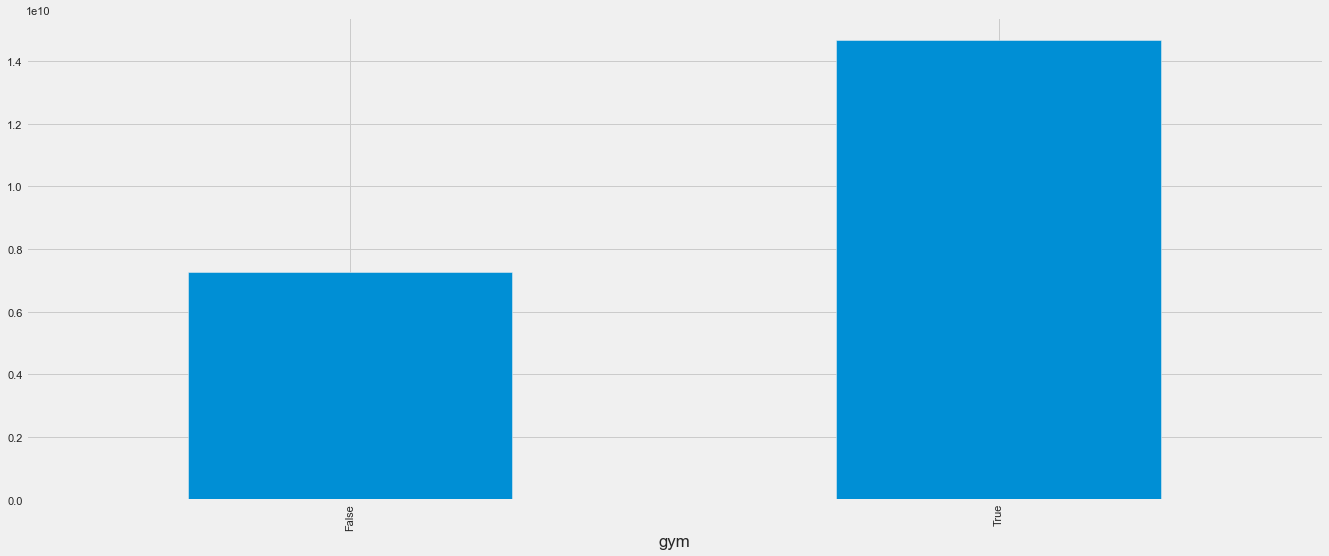

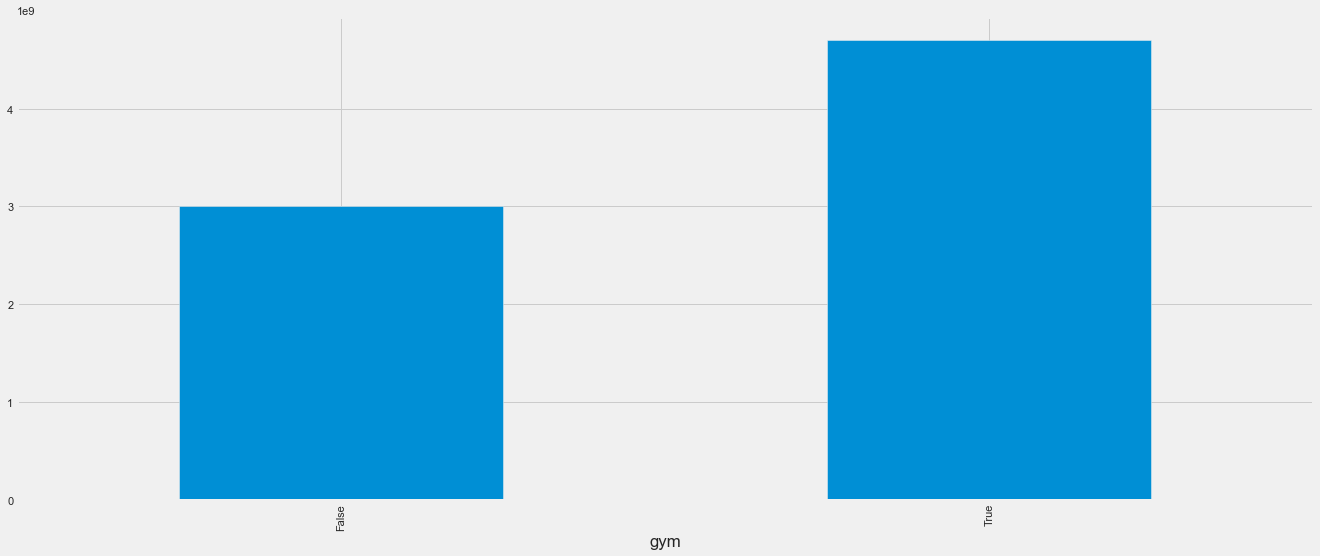

In [25]:
for i in cat:
    print(i)
    df.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

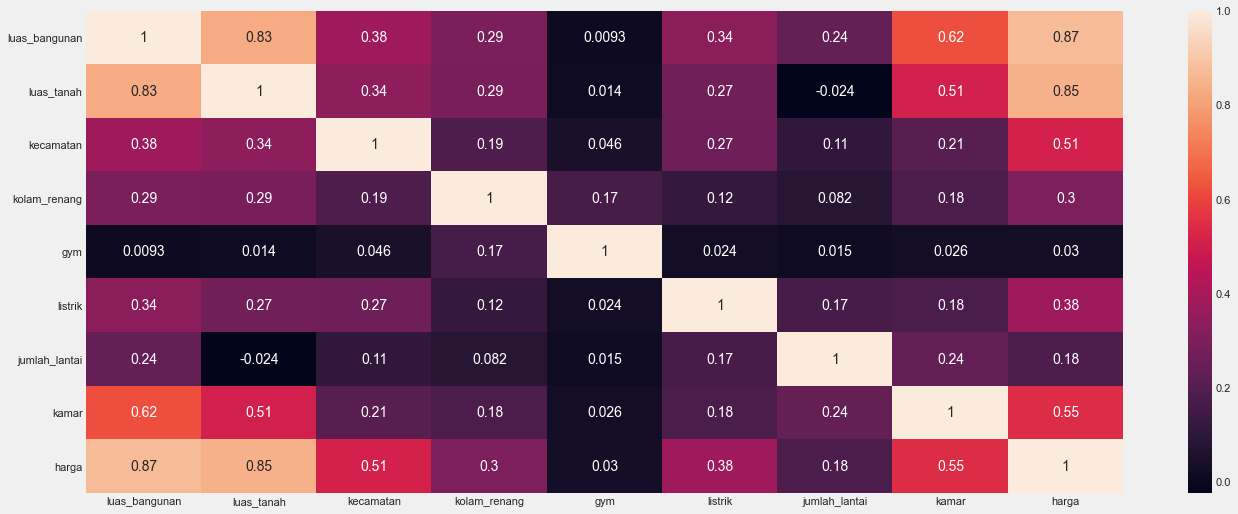

In [26]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()